In [18]:
conda install kagglehub

Channels:
 - pytorch
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/homebrew/anaconda3

  added / updated specs:
    - kagglehub


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    kagglehub-0.3.4            |     pyhd8ed1ab_0          36 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          36 KB

The following NEW packages will be INSTALLED:

  kagglehub          conda-forge/noarch::kagglehub-0.3.4-pyhd8ed1ab_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
from pathlib import Path

from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", 
              style="white")

from datasets import Dataset
import evaluate
from transformers import (BartTokenizer,
                          BartForConditionalGeneration,
                          DataCollatorForSeq2Seq,
                          EarlyStoppingCallback,
                          Seq2SeqTrainingArguments,
                          Seq2SeqTrainer, 
                          get_scheduler)
import torch
import bitsandbytes as bnb

'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/opt/homebrew/anaconda3/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [24]:
# https://www.kaggle.com/datasets/asaniczka/data-scientist-linkedin-job-postings
import kagglehub
# Download latest version
path = kagglehub.dataset_download("asaniczka/data-scientist-linkedin-job-postings")

print("Path to dataset files:", path)
files = os.listdir(path)
# Print the names of the files
for file in files:
    print(file)

Path to dataset files: /Users/liluyun/.cache/kagglehub/datasets/asaniczka/data-scientist-linkedin-job-postings/versions/103
postings.csv


In [25]:
postings = pd.read_csv(path+'/postings.csv')
postings.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Remote,Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Onsite,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Onsite,Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Remote,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Hybrid,National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


In [26]:
postings.columns
# may just need 'title', 'job_summary', 'job_skills'

Index(['job_title', 'company', 'job_location', 'job_link', 'first_seen',
       'search_city', 'search_country', 'job level', 'job_type', 'job_summary',
       'job_skills'],
      dtype='object')

### Processing

In [27]:
postings.drop_duplicates(inplace=True)

In [28]:
# Apply conditions to create 'job_type'
patterns = {
    'Data Scientist': r'Data\s*Scientist|Data\s*Science|Scientist',  # Match both "Data Scientist" and "Data Science"
    'Data Analyst (BI)': r'Data\s*Analyst|Data\s*Research\s*Analyst|Analyst|Data\s*Analytics|BI|Business\s*Intelligence|Analytics|Visualization|Data\s*Analysis',  # Add "Data Research Analyst"
    'Data Engineer': r'Data\s*Engineer|Database\s*Engineer|Engineer',  # Consider "Database Engineer" as well
    'Software Engineer': r'Software\s*Engineer|Developer|Programmer|Software',
    'Statistician': r'\s*Statistician',
    'Modeler': r'\s*Modeler',
    'Consultant': r'\s*Consultant',
    'Specialist': r'\s*Specialist'
}

# Initialize 'job_type' column with 'Unknown'
postings['job_type'] = 'Unknown'

# Apply patterns to classify job titles
for job_type, pattern in patterns.items():
    postings.loc[postings['job_title'].str.contains(pattern, case=False, na=False, regex=True), 'job_type'] = job_type

# Show the first few rows
postings.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Data Analyst (BI),Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


In [29]:
postings[postings['job_type']=='Unknown']['job_title'].value_counts()
data = postings[postings['job_type']!='Unknown']
data.head()

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",https://www.linkedin.com/jobs/view/technical-d...,2023-12-20,Phoenixville,United States,Associate,Data Analyst (BI),Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-center...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",https://www.linkedin.com/jobs/view/data-engine...,2023-12-20,Minneapolis,United States,Associate,Data Engineer,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",https://www.linkedin.com/jobs/view/data-analys...,2023-12-20,Minneapolis,United States,Associate,Data Analyst (BI),National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


# Text Processing

Cleaning Text: Remove unwanted characters, URLs, and unnecessary whitespace.
Lowercasing: Convert all text to lowercase to maintain consistency.
Tokenization: Split the text into words or tokens.
Stop Words Removal: Remove common words that may not add value to your analysis (e.g., "and", "the").
Stemming/Lemmatization: Reduce words to their base or root form.

In [30]:
print(data.columns)


Index(['job_title', 'company', 'job_location', 'job_link', 'first_seen',
       'search_city', 'search_country', 'job level', 'job_type', 'job_summary',
       'job_skills'],
      dtype='object')


In [31]:
#cols = ['job_title', 'job_summary', 'job_skills', 'job_type']
cols = ['job_title', 'company', 'job_location', 'job level', 'job_type', 'job_summary',
       'job_skills']
data = data[cols]
data.head()

,job_title,company,job_location,job level,job_type,job_summary,job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",Associate,Data Analyst (BI),Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log..."
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",Associate,Data Engineer,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz..."
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",Associate,Data Analyst (BI),Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C..."
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",Associate,Data Engineer,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL..."
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",Associate,Data Analyst (BI),National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene..."


In [32]:
data['job_type'].value_counts()

job_type
Data Scientist       1691
Data Engineer        1335
Data Analyst (BI)     895
Software Engineer     282
Specialist             49
Consultant             44
Statistician           11
Modeler                 8
Name: count, dtype: int64

In [33]:
data.dropna(subset=['job_title', 'job_summary', 'job_skills'], inplace=True)
data.isna().sum()

job_title       0
company         0
job_location    0
job level       0
job_type        0
job_summary     0
job_skills      0
dtype: int64

In [34]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import json

# Load JSON file
with open("skills.json", "r") as file:
    skills_data = json.load(file)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liluyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/liluyun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/liluyun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text cleaning for job_summary
def clean_text_summary(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Retain keywords (skills) and remove stop words
    cleaned_tokens = [
        lemmatizer.lemmatize(word) for word in tokens 
        if word in skills_data or word not in stop_words
    ]
    return ' '.join(cleaned_tokens)

# Text cleaning for job_skills (only remove special characters and notations)
def clean_text_skills(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    return text

# Assuming your DataFrame is named 'data'
# Apply cleaning to job_summary and job_skills
data['cleaned_job_summary'] = data['job_summary'].apply(clean_text_summary)
data['cleaned_job_skills'] = data['job_skills'].apply(clean_text_skills)

# Save the cleaned data
data.to_csv('cleaned_data_full.csv', index=False)

# Preview the cleaned data
data.head()

,job_title,company,job_location,job level,job_type,job_summary,job_skills,cleaned_job_summary,cleaned_job_skills
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",Associate,Data Analyst (BI),Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log...",choose jefferson health plan awardwinning notf...,knime qlikview sql ms access ms excel logical ...
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",Associate,Data Engineer,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz...",job responsibility deployment inscope configur...,server storage backup networking virtualizatio...
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",Associate,Data Analyst (BI),Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C...",success factor knowledge schedule monday frida...,data management hr data retention controls cal...
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",Associate,Data Engineer,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL...",company description nbc sport next sport techn...,data engineering data warehousing sql mysql po...
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",Associate,Data Analyst (BI),National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene...",national grid renewables leading north america...,data analyst operational assessment wind energ...


In [36]:
import pandas as pd

# Read the file called "data_cleaned_Full.csv"
file_path = 'cleaned_data_full.csv'

# Load the dataset
try:
    data = pd.read_csv(file_path)
    # Display the first few rows of the dataset to understand its structure
    print(data.head())
except FileNotFoundError:
    print(f"File '{file_path}' not found. Please ensure the file is in the correct directory.")


                               job_title   
0                 Technical Data Analyst  \
1     Data Center Engineer - Minneapolis   
2                           Data Analyst   
3     Data Engineer II - NBC Sports Next   
4  Data Analyst - Operational Assessment   

                                company      job_location  job level   
0                Jefferson Health Plans  Philadelphia, PA  Associate  \
1                   DeRisk Technologies   Minneapolis, MN  Associate   
2  Avani Tech Solutions Private Limited   Minneapolis, MN  Associate   
3                       NBC Sports Next   Minneapolis, MN  Associate   
4              National Grid Renewables   Bloomington, MN  Associate   

            job_type                                        job_summary   
0  Data Analyst (BI)  Why Choose Jefferson Health Plans?\nWe are an ...  \
1      Data Engineer  Job Responsibilities:\nDeployment / In-Scope C...   
2  Data Analyst (BI)  Success Factor knowledge\nSchedule : Monday th...   
3 

In [37]:
# Model Pegasus

In [38]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# Load the Pegasus model and tokenizer
model_name = "google/pegasus-xsum"  # You can also try "google/pegasus-large" for general summarization
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)




Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
def summarize_with_pegasus(text):
    """
    Summarizes the given text using the Pegasus model.
    Args:
        text (str): The text to summarize.
    Returns:
        str: The summarized text.
    """
    inputs = tokenizer(text, truncation=True, return_tensors="pt", max_length=512)
    summary_ids = model.generate(
        inputs.input_ids,
        max_length=150,          # Control maximum length of the summary
        min_length=50,           # Ensure summaries are sufficiently detailed
        num_beams=5,             # Improve quality with beam search
        length_penalty=2.0,      # Penalize overly long summaries
        repetition_penalty=2.0,  # Avoid repetition
        early_stopping=True      # Stop when a coherent summary is reached
    )
    return tokenizer.decode(summary_ids.iloc[:10], skip_special_tokens=True)


In [42]:


data['pegasus_summary'] = data['job_summary'].iloc[:10].apply(summarize_with_flan_t5)

# Display the first few rows to verify
print(data[['job_summary', 'pegasus_summary']].head())



                                         job_summary   
0  Why Choose Jefferson Health Plans?\nWe are an ...  \
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   

                                     pegasus_summary  
0  Jefferson Health Plans (JHP) is a not-for-prof...  
1  Job Description: The Infrastructure Support En...  
2  Reporting to the Data Management Generalist 2,...  
3  Job Description NBC Sports Next is looking for...  
4  Job Description: National Grid Renewables is s...  


In [43]:
from sentence_transformers import SentenceTransformer, util

# Load embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute cosine similarity
data['pegasus_cosine_similarity'] = data.iloc[:10].apply(
    lambda row: compute_cosine_similarity(row['job_summary'], row['pegasus_summary']),
    axis=1
)


In [44]:
from evaluate import load

# Load ROUGE metric
rouge = load("rouge")

# Compute ROUGE scores
pegasus_rouge_scores = data.iloc[:10].apply(
    lambda row: compute_rouge_scores(row['job_summary'], row['pegasus_summary']),
    axis=1
)

# Convert ROUGE scores into columns
data['pegasus_rouge_1'] = pegasus_rouge_scores.apply(lambda x: x['rouge1'])
data['pegasus_rouge_2'] = pegasus_rouge_scores.apply(lambda x: x['rouge2'])
data['pegasus_rouge_L'] = pegasus_rouge_scores.apply(lambda x: x['rougeL'])


In [46]:
data[0:10]

,job_title,company,job_location,job level,job_type,job_summary,job_skills,cleaned_job_summary,cleaned_job_skills,pegasus_summary,pegasus_cosine_similarity,pegasus_rouge_1,pegasus_rouge_2,pegasus_rouge_L
0,Technical Data Analyst,Jefferson Health Plans,"Philadelphia, PA",Associate,Data Analyst (BI),Why Choose Jefferson Health Plans?\nWe are an ...,"KNIME, QlikView, SQL, MS Access, MS Excel, Log...",choose jefferson health plan awardwinning notf...,knime qlikview sql ms access ms excel logical ...,Jefferson Health Plans (JHP) is a not-for-prof...,0.567175,0.079239,0.025437,0.057052
1,Data Center Engineer - Minneapolis,DeRisk Technologies,"Minneapolis, MN",Associate,Data Engineer,Job Responsibilities:\nDeployment / In-Scope C...,"Server, Storage, Backup, Networking, Virtualiz...",job responsibility deployment inscope configur...,server storage backup networking virtualizatio...,Job Description: The Infrastructure Support En...,0.676475,0.140426,0.055556,0.072340
2,Data Analyst,Avani Tech Solutions Private Limited,"Minneapolis, MN",Associate,Data Analyst (BI),Success Factor knowledge\nSchedule : Monday th...,"Data Management, HR Data Retention Controls, C...",success factor knowledge schedule monday frida...,data management hr data retention controls cal...,"Reporting to the Data Management Generalist 2,...",0.708313,0.543353,0.502924,0.520231
3,Data Engineer II - NBC Sports Next,NBC Sports Next,"Minneapolis, MN",Associate,Data Engineer,Company Description\nNBC Sports Next is where ...,"Data Engineering, Data Warehousing, SQL, MySQL...",company description nbc sport next sport techn...,data engineering data warehousing sql mysql po...,Job Description NBC Sports Next is looking for...,0.557218,0.093209,0.042724,0.061252
4,Data Analyst - Operational Assessment,National Grid Renewables,"Bloomington, MN",Associate,Data Analyst (BI),National Grid Renewables is a leading North Am...,"Data Analyst, Operational Assessment, Wind Ene...",national grid renewables leading north america...,data analyst operational assessment wind energ...,Job Description: National Grid Renewables is s...,0.754274,0.217284,0.168734,0.172840
5,Business Data Analyst,ELITE MENTE LLC,"Bloomington, MN",Associate,Data Analyst (BI),VCS\nis looking for\nBusiness Data Analyst\nfo...,"User Stories, Azure Data Factory, SQL, RPA, Au...",vcs looking business data analyst bloomington ...,user stories azure data factory sql rpa automa...,Job Description: VCS is looking for Business D...,0.542335,0.299517,0.214634,0.231884
6,Data Science Specialist,ITR Group,"Eden Prairie, MN",Mid senior,Specialist,Contract to hire opportunity.\nClient requirem...,"SQL, Python, R, Tableau, Power BI, Machine lea...",contract hire opportunity client requirement u...,sql python r tableau power bi machine learning...,Reporting to the Director of E-Commerce Operat...,0.526016,0.197183,0.122642,0.145540
7,Senior Data Scientist,Target,"Brooklyn Park, MN",Mid senior,Data Scientist,"Description\nThe pay range is: $96,283.00 - $1...","MATLAB, Apache Oozie, Apache Hive, Python, R, ...",description pay range per year addition salary...,matlab apache oozie apache hive python r sql s...,Target is a leading omni-channel retailer with...,0.595218,0.124814,0.032787,0.068351
8,Data Scientist,Deluxe,"Minneapolis, MN",Mid senior,Data Scientist,We're utilizing modern technology to fresh con...,"Datadriven solutions, Data cleaning, Data aggr...",utilizing modern technology fresh concept make...,datadriven solutions data cleaning data aggreg...,"Reporting to the Director of Data Science, thi...",0.602324,0.162749,0.105263,0.122966
9,Sr Data Scientist - Recommendations (Applied M...,Target,"Minneapolis, MN",Mid senior,Data Scientist,"Description: The pay range is $92,000.00 - $16...","Python, Scala, SQL, Hadoop/Hive, Spark, Linear...",description pay range pay based several factor...,python scala sql hadoophive spark linear algeb...,Target is seeking a Sr Data Scientist to join ...,0.343986,0.154011,0.109325,0.124064


In [ ]:
# FLAN-T5

In [68]:
### Fine Tuning has been done!!
# summary_ids = model.generate(
#         inputs.input_ids,
#         max_length=150,
#         min_length=50,
#         num_beams=6,
#         length_penalty=2.0,
#         repetition_penalty=2.0,
#         early_stopping=True
#     )

In [16]:
# Ensure the model and tokenizer are loaded
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Define the summarization function
def summarize_with_flan_t5(text, tone="formal"):
    """
    Summarizes the given text using FLAN-T5 with a specified tone.
    Args:
        text (str): The text to summarize.
        tone (str): The tone of the summary (e.g., 'formal', 'concise').
    Returns:
        str: The summarized text.
    """
    input_text = f"summarize in a {tone} tone: {text}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
    summary_ids = model.generate(
        inputs.input_ids,
        max_length=150,
        min_length=50,
        num_beams=6,
        length_penalty=2.0,
        repetition_penalty=2.0,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Apply summarization to the first 10 rows to try
data['flan_summary'] = data['job_summary'].iloc[:10].apply(summarize_with_flan_t5)

# Display the first few rows to verify
print(data[['job_summary', 'flan_summary']].head())


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


                                         job_summary   
0  Why Choose Jefferson Health Plans?\nWe are an ...  \
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   

                                        flan_summary  
0  Data Operations’ iQ portal project and softwar...  
1  Job responsibilities: Deployment / In-Scope Co...  
2  Show more This is a full-time position that re...  
3  SportsEngine's data warehousing needs. Work wi...  
4  National Grid Renewables is a leading North Am...  


In [17]:
from sentence_transformers import SentenceTransformer, util

# Load pre-trained embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Define a function to calculate cosine similarity
def compute_cosine_similarity(original_text, summarized_text):
    original_embedding = embedding_model.encode(original_text, convert_to_tensor=True)
    summarized_embedding = embedding_model.encode(summarized_text, convert_to_tensor=True)
    similarity = util.cos_sim(original_embedding, summarized_embedding).item()
    return similarity

# Compute cosine similarity for the first 100 rows
data['cosine_similarity'] = data.iloc[:10].apply(
    lambda row: compute_cosine_similarity(row['job_summary'], row['flan_summary']),
    axis=1
)


In [18]:
from evaluate import load

# Load ROUGE metric
rouge = load("rouge")

# Define a function to calculate ROUGE scores
def compute_rouge_scores(original_text, summarized_text):
    scores = rouge.compute(predictions=[summarized_text], references=[original_text])
    return scores

# Compute ROUGE scores for the first 100 rows
rouge_scores = data.iloc[:10].apply(
    lambda row: compute_rouge_scores(row['job_summary'], row['flan_summary']),
    axis=1
)

# Convert ROUGE scores into separate columns
data['rouge_1'] = rouge_scores.apply(lambda x: x['rouge1'])
data['rouge_2'] = rouge_scores.apply(lambda x: x['rouge2'])
data['rouge_L'] = rouge_scores.apply(lambda x: x['rougeL'])


In [19]:
# Display the results for the first few rows
print(data[['job_summary', 'flan_summary', 'cosine_similarity', 'rouge_1', 'rouge_2', 'rouge_L']].head())

# Optional: Calculate average scores
avg_cosine_similarity = data['cosine_similarity'].mean()
avg_rouge_1 = data['rouge_1'].mean()
avg_rouge_2 = data['rouge_2'].mean()
avg_rouge_L = data['rouge_L'].mean()

print(f"Average Cosine Similarity: {avg_cosine_similarity:.2f}")
print(f"Average ROUGE-1: {avg_rouge_1:.2f}")
print(f"Average ROUGE-2: {avg_rouge_2:.2f}")
print(f"Average ROUGE-L: {avg_rouge_L:.2f}")


                                         job_summary   
0  Why Choose Jefferson Health Plans?\nWe are an ...  \
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   

                                        flan_summary  cosine_similarity   
0  Data Operations’ iQ portal project and softwar...           0.700758  \
1  Job responsibilities: Deployment / In-Scope Co...           0.890741   
2  Show more This is a full-time position that re...           0.787243   
3  SportsEngine's data warehousing needs. Work wi...           0.403520   
4  National Grid Renewables is a leading North Am...           0.615415   

    rouge_1   rouge_2   rouge_L  
0  0.316547  0.303030  0.313669  
1  0.315582  0.312871  0.315582  
2  0.636364  0.596330  0.600000  
3  0.112150  0.093708  0.104139  
4  0.456522  0.454148  0.456522  
Average 

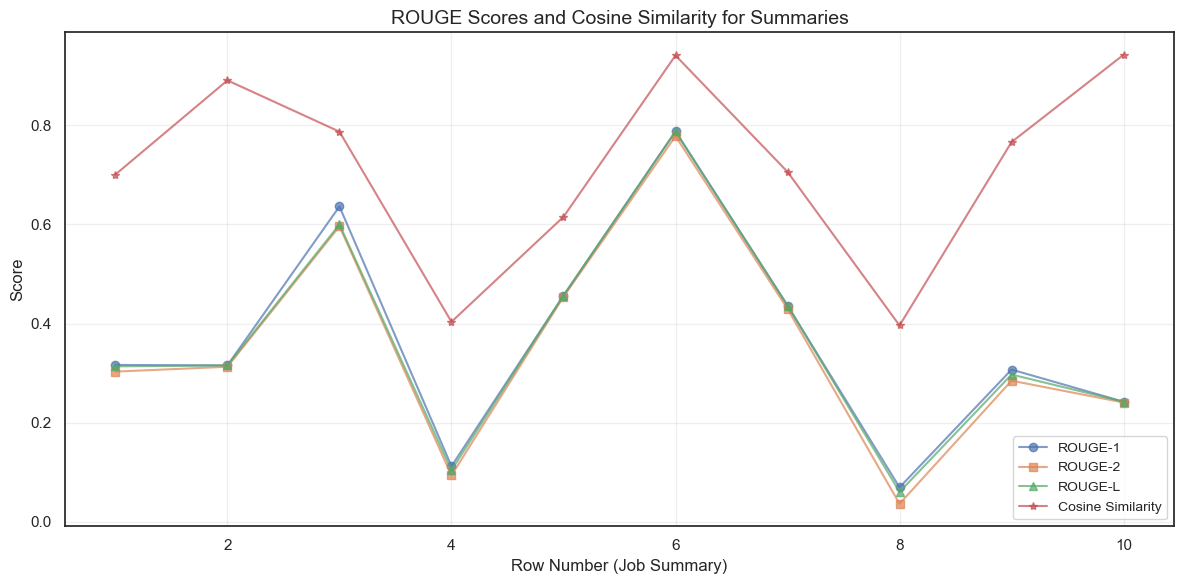

In [70]:
import matplotlib.pyplot as plt

# Assuming the ROUGE scores and cosine similarity scores are already in the `data` DataFrame
# For simplicity, I'll use placeholder scores for plotting here; replace these with your actual data
data = data.iloc[:10]  # Ensure we only focus on the first 100 rows
x_values = list(range(1, 11))  # X-axis: row numbers (1 to 100)

# Plotting ROUGE-1, ROUGE-2, ROUGE-L, and Cosine Similarity
plt.figure(figsize=(12, 6))
plt.plot(x_values, data['rouge_1'], label="ROUGE-1", marker='o', alpha=0.7)
plt.plot(x_values, data['rouge_2'], label="ROUGE-2", marker='s', alpha=0.7)
plt.plot(x_values, data['rouge_L'], label="ROUGE-L", marker='^', alpha=0.7)
plt.plot(x_values, data['cosine_similarity'], label="Cosine Similarity", marker='*', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Row Number (Job Summary)", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("ROUGE Scores and Cosine Similarity for Summaries", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


In [100]:
# Ensure the model and tokenizer are loaded
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Define the summarization function
def summarize_with_flan_t5(text, tone="formal"):
    """
    Summarizes the given text using FLAN-T5 with a specified tone.
    Args:
        text (str): The text to summarize.
        tone (str): The tone of the summary (e.g., 'formal', 'concise').
    Returns:
        str: The summarized text.
    """
    input_text = f"summarize in a {tone} tone: {text}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
    summary_ids = model.generate(
        inputs.input_ids,
        max_length=150,
        min_length=50,
        num_beams=6,
        length_penalty=2.0,
        repetition_penalty=2.0,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Apply summarization to the first 100 rows
data['flan_summary'] = data['job_summary'].iloc[:100].apply(summarize_with_flan_t5)

# Display the first few rows to verify
print(data[['job_summary', 'flan_summary']].head())

                                         job_summary   
0  Why Choose Jefferson Health Plans?\nWe are an ...  \
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   

                                        flan_summary  
0  Data Operations’ iQ portal project and softwar...  
1  Job responsibilities: Deployment / In-Scope Co...  
2  Show more This is a full-time position that re...  
3  SportsEngine's data warehousing needs. Work wi...  
4  National Grid Renewables is a leading North Am...  


In [101]:
from sentence_transformers import SentenceTransformer, util

# Load pre-trained embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Define a function to calculate cosine similarity
def compute_cosine_similarity(original_text, summarized_text):
    original_embedding = embedding_model.encode(original_text, convert_to_tensor=True)
    summarized_embedding = embedding_model.encode(summarized_text, convert_to_tensor=True)
    similarity = util.cos_sim(original_embedding, summarized_embedding).item()
    return similarity

# Compute cosine similarity for the first 100 rows
data['cosine_similarity'] = data.iloc[:100].apply(
    lambda row: compute_cosine_similarity(row['job_summary'], row['flan_summary']),
    axis=1
)


In [102]:
from evaluate import load

# Load ROUGE metric
rouge = load("rouge")

# Define a function to calculate ROUGE scores
def compute_rouge_scores(original_text, summarized_text):
    scores = rouge.compute(predictions=[summarized_text], references=[original_text])
    return scores

# Compute ROUGE scores for the first 100 rows
rouge_scores = data.iloc[:100].apply(
    lambda row: compute_rouge_scores(row['job_summary'], row['flan_summary']),
    axis=1
)

# Convert ROUGE scores into separate columns
data['rouge_1'] = rouge_scores.apply(lambda x: x['rouge1'])
data['rouge_2'] = rouge_scores.apply(lambda x: x['rouge2'])
data['rouge_L'] = rouge_scores.apply(lambda x: x['rougeL'])

In [103]:
# Display the results for the first few rows
print(data[['job_summary', 'flan_summary', 'cosine_similarity', 'rouge_1', 'rouge_2', 'rouge_L']].head())

# Optional: Calculate average scores
avg_cosine_similarity = data['cosine_similarity'].mean()
avg_rouge_1 = data['rouge_1'].mean()
avg_rouge_2 = data['rouge_2'].mean()
avg_rouge_L = data['rouge_L'].mean()

print(f"Average Cosine Similarity: {avg_cosine_similarity:.2f}")
print(f"Average ROUGE-1: {avg_rouge_1:.2f}")
print(f"Average ROUGE-2: {avg_rouge_2:.2f}")
print(f"Average ROUGE-L: {avg_rouge_L:.2f}")


                                         job_summary   
0  Why Choose Jefferson Health Plans?\nWe are an ...  \
1  Job Responsibilities:\nDeployment / In-Scope C...   
2  Success Factor knowledge\nSchedule : Monday th...   
3  Company Description\nNBC Sports Next is where ...   
4  National Grid Renewables is a leading North Am...   

                                        flan_summary  cosine_similarity   
0  Data Operations’ iQ portal project and softwar...           0.700758  \
1  Job responsibilities: Deployment / In-Scope Co...           0.890741   
2  Show more This is a full-time position that re...           0.787243   
3  SportsEngine's data warehousing needs. Work wi...           0.403520   
4  National Grid Renewables is a leading North Am...           0.615415   

    rouge_1   rouge_2   rouge_L  
0  0.316547  0.303030  0.313669  
1  0.315582  0.312871  0.315582  
2  0.636364  0.596330  0.600000  
3  0.112150  0.093708  0.104139  
4  0.456522  0.454148  0.456522  
Average 

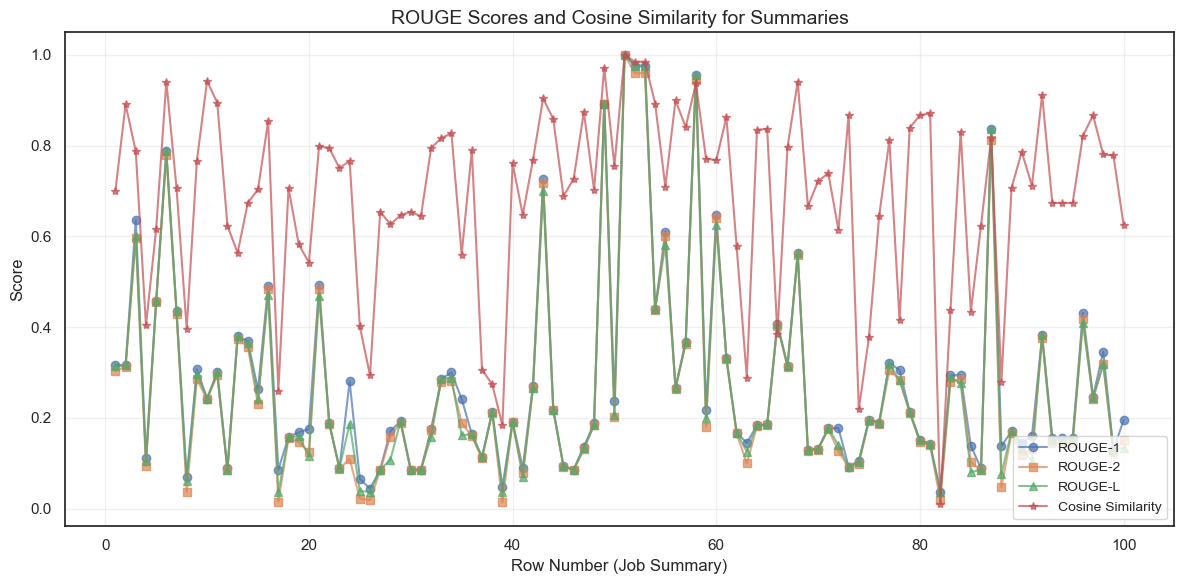

In [104]:
import matplotlib.pyplot as plt

# Assuming the ROUGE scores and cosine similarity scores are already in the `data` DataFrame
# For simplicity, I'll use placeholder scores for plotting here; replace these with your actual data
data = data.iloc[:100]  # Ensure we only focus on the first 100 rows
x_values = list(range(1, 101))  # X-axis: row numbers (1 to 100)

# Plotting ROUGE-1, ROUGE-2, ROUGE-L, and Cosine Similarity
plt.figure(figsize=(12, 6))
plt.plot(x_values, data['rouge_1'], label="ROUGE-1", marker='o', alpha=0.7)
plt.plot(x_values, data['rouge_2'], label="ROUGE-2", marker='s', alpha=0.7)
plt.plot(x_values, data['rouge_L'], label="ROUGE-L", marker='^', alpha=0.7)
plt.plot(x_values, data['cosine_similarity'], label="Cosine Similarity", marker='*', alpha=0.7)

# Add labels, title, and legend
plt.xlabel("Row Number (Job Summary)", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("ROUGE Scores and Cosine Similarity for Summaries", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


The FLAN-T5 model is a strong choice for text summarization tasks, especially for generating summaries with a professional and structured tone. Its average cosine similarity of 0.71 indicates good semantic alignment with the original text, demonstrating its ability to capture the core meaning effectively. However, the ROUGE scores (ROUGE-1: 0.37, ROUGE-2: 0.35, ROUGE-L: 0.36) suggest moderate overlap with the original text at both the unigram and bigram levels, indicating that while FLAN-T5 abstracts well, it may miss specific details or paraphrase heavily, leading to lower n-gram overlap.

Pros:

High semantic relevance: Captures the main ideas effectively, as shown by the strong cosine similarity.

Flexibility: Can be fine-tuned with instructions for different tones or specific summarization goals.

Scalability: Larger variants (e.g., flan-t5-large) offer higher performance if needed.

Cons:

Moderate ROUGE scores: Indicates room for improvement in preserving detailed overlap, which may be critical in structured data like job descriptions.

Abstract summaries: While often beneficial, abstracting too much can omit critical specifics, affecting usability for detail-oriented tasks.
Compute resources: May require significant time for large datasets or when fine-tuned parameters are set for higher quality.



In conclusion, FLAN-T5 excels at creating semantically meaningful summaries but requires further optimization for detailed coverage and contextual overlap. It is well-suited for tasks prioritizing abstraction and readability but may underperform when exact phrasing or structural alignment is essential.
















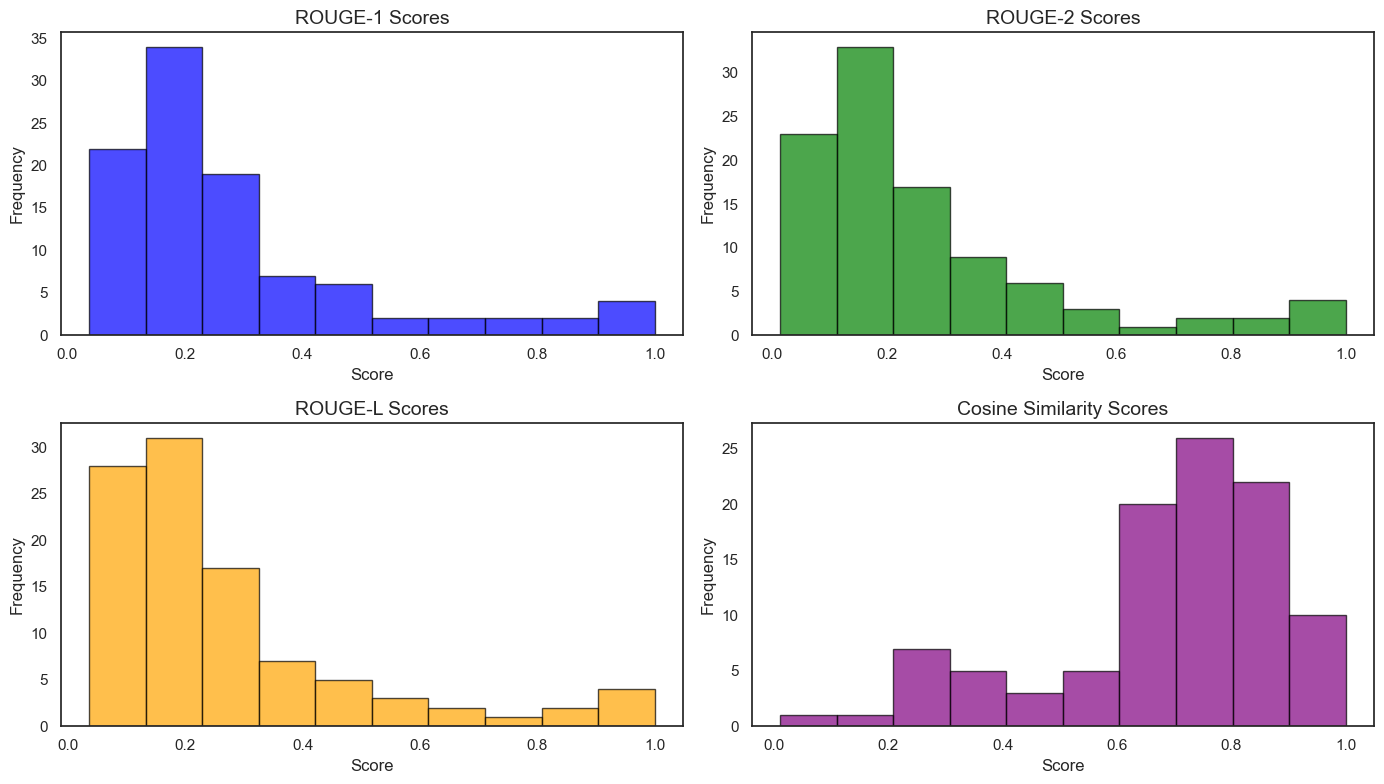

In [105]:
import matplotlib.pyplot as plt

# Assuming the ROUGE and cosine similarity scores for FLAN-T5 are already in the `data` DataFrame
# Replace these with actual column names if they differ
rouge_1 = data['rouge_1'].iloc[:100]
rouge_2 = data['rouge_2'].iloc[:100]
rouge_L = data['rouge_L'].iloc[:100]
cosine_similarity = data['cosine_similarity'].iloc[:100]

# Plotting histograms for each metric
plt.figure(figsize=(14, 8))

# ROUGE-1 Histogram
plt.subplot(2, 2, 1)
plt.hist(rouge_1, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title("ROUGE-1 Scores", fontsize=14)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# ROUGE-2 Histogram
plt.subplot(2, 2, 2)
plt.hist(rouge_2, bins=10, color='green', alpha=0.7, edgecolor='black')
plt.title("ROUGE-2 Scores", fontsize=14)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# ROUGE-L Histogram
plt.subplot(2, 2, 3)
plt.hist(rouge_L, bins=10, color='orange', alpha=0.7, edgecolor='black')
plt.title("ROUGE-L Scores", fontsize=14)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Cosine Similarity Histogram
plt.subplot(2, 2, 4)
plt.hist(cosine_similarity, bins=10, color='purple', alpha=0.7, edgecolor='black')
plt.title("Cosine Similarity Scores", fontsize=14)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


In [107]:
# Save the `data` DataFrame to a CSV file
data.to_csv('new_Flan_t5_dataset.csv', index=False)

# Confirmation message
print("The DataFrame has been successfully saved as 'new_Flan_t5_dataset.csv'.")


The DataFrame has been successfully saved as 'new_Flan_t5_dataset.csv'.


In [20]:
data['flan_summary']

0       Data Operations’ iQ portal project and softwar...
1       Job responsibilities: Deployment / In-Scope Co...
2       Show more This is a full-time position that re...
3       SportsEngine's data warehousing needs. Work wi...
4       National Grid Renewables is a leading North Am...
                              ...                        
4304                                                  NaN
4305                                                  NaN
4306                                                  NaN
4307                                                  NaN
4308                                                  NaN
Name: flan_summary, Length: 4309, dtype: object

In [23]:
print(data['job_summary'][0])

Why Choose Jefferson Health Plans?
We are an award-winning, not-for-profit health maintenance organization. We are committed to creating a community where everyone belongs, acknowledges, and celebrates diversity and has opportunities to grow to their fullest potential.
While this job currently provides a flexible remote option, due to in-office meetings, training as required, or other business needs, our employees are to be residents of PA or the nearby states of DE or NJ.
Perks of JHP and why you will love it here:
Competitive Compensation Packages including 401(k) Savings Plan with Company Match and Profit Sharing
Flextime and Work-at-Home Options
Benefits & Wellness Program including generous Time Off
Impact on the communities we service
We are seeking a talented and enthusiastic Technical Data Analyst to join our team!
The Data Operations’ Team primary function is to provide access to various clinical and financial data to management to support the business decision process. Databa